# Полносвязные сетки

In [2]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

%matplotlib inline

SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [298]:
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
display(fetch_california_housing(as_frame=True).frame.head())
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [300]:
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [301]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [302]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

Epoch 99: 100%|██████████████| 1445/1445 [00:04<00:00, 359.65batch/s, mse=0.349]


MSE: 0.32
RMSE: 0.56


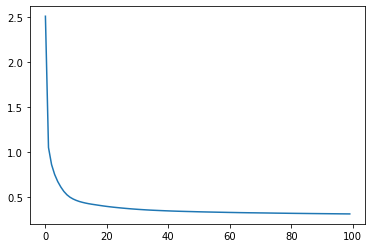

[ 2.60980000e+00  1.30000000e+01  5.04255319e+00  1.10453284e+00
  2.95700000e+03  2.73543016e+00  3.80700000e+01 -1.22240000e+02] -> [1.3723598] (expected [1.625])
[ 4.35330000e+00  3.50000000e+01  4.98776224e+00  1.02797203e+00
  1.76100000e+03  3.07867133e+00  3.76900000e+01 -1.21780000e+02] -> [1.7954704] (expected [1.684])
[   2.9688       42.            4.16254417    0.92226148  804.
    2.8409894    33.99       -117.36      ] -> [1.0500119] (expected [0.929])
[ 1.39270000e+00  3.00000000e+01  4.06785317e+00  1.05116796e+00
  2.92500000e+03  3.25361513e+00  3.85200000e+01 -1.21430000e+02] -> [0.65699434] (expected [0.783])
[   2.5156       32.            4.83333333    1.04861111  443.
    3.07638889   37.83       -121.28      ] -> [0.96162856] (expected [0.863])


In [303]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")



In [304]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

In [321]:
data[60].describecribe()

count     208
unique      2
top         M
freq      111
Name: 60, dtype: object

In [14]:
# Binary encoding of labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [312]:
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

11161
11041


In [318]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc


In [319]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [320]:
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

KeyError: '[60, 61, 62, 63, 64, 65, 66, 68, 71, 73, 75, 76, 77, 82, 83, 84, 85, 86, 87, 89, 92, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 127, 128, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144] not in index'

In [23]:
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

Accuracy (deep): 0.79
Accuracy (deep): 0.83
Accuracy (deep): 0.86
Accuracy (deep): 0.86
Accuracy (deep): 0.79


In [24]:
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Wide: 77.24% (+/- 8.33%)
Deep: 82.76% (+/- 3.08%)


In [25]:
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a deep model
Final model accuracy: 82.54%


[0.0231 0.0351 0.003  0.0304 0.0339 0.086  0.1738 0.1351 0.1063 0.0347
 0.0575 0.1382 0.2274 0.4038 0.5223 0.6847 0.7521 0.776  0.7708 0.8627
 1.     0.8873 0.8057 0.876  0.9066 0.943  0.8846 0.65   0.297  0.2423
 0.2992 0.2285 0.2277 0.1529 0.1037 0.0352 0.1073 0.1373 0.1331 0.1454
 0.1115 0.044  0.0762 0.1381 0.0831 0.0654 0.0844 0.0595 0.0497 0.0313
 0.0154 0.0106 0.0097 0.0022 0.0052 0.0072 0.0056 0.0038 0.0043 0.003 ] -> [0.8517905] (expected [1.])
[2.160e-02 1.240e-02 1.740e-02 1.520e-02 6.080e-02 1.026e-01 1.139e-01
 8.770e-02 1.160e-01 8.660e-02 1.564e-01 7.800e-02 9.970e-02 9.150e-02
 6.620e-02 1.134e-01 1.740e-01 2.573e-01 3.294e-01 3.910e-01 5.438e-01
 6.115e-01 7.022e-01 7.610e-01 7.973e-01 9.105e-01 8.807e-01 7.949e-01
 7.990e-01 7.180e-01 6.407e-01 6.312e-01 5.929e-01 6.168e-01 6.498e-01
 6.764e-01 6.253e-01 5.117e-01 3.890e-01 3.273e-01 2.509e-01 1.530e-01
 1.323e-01 1.657e-01 1.215e-01 9.780e-02 4.520e-02 2.730e-02 1.790e-02
 9.200e-03 1.800e-03 5.200e-03 4.900e-03 9.60

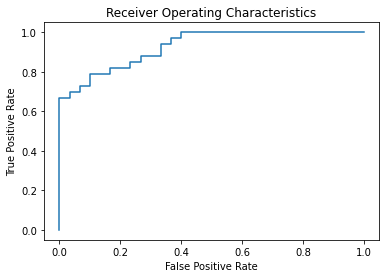

In [26]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [342]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(10000)

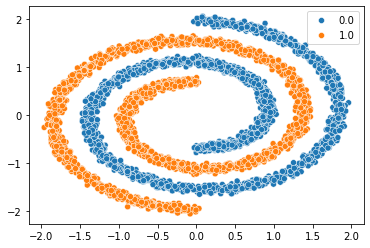

In [327]:
import seaborn as sns

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

In [330]:
y.shape

(5000,)

In [343]:
y = y.reshape(-1, 1)
y.shape

(5000, 1)

In [339]:
class NextDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 8)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(8, 8)
        self.act2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(8, 4)
        self.act3 = nn.Tanh()
        self.layer4 = nn.Linear(4, 2)
        self.act4 = nn.Tanh()
        self.out = nn.Linear(2, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.sig(self.out(x))
        return x

In [344]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [355]:
# Helper function to train one model
import torch.optim.lr_scheduler as lr_scheduler
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    n_epochs = 100   # number of epochs to run
    batch_size = 32  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    preds_history = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        
        scheduler.step()
        model.eval()
        y_pred = model(X_val)
        
        if (epoch % 2 == 0 and epoch < 15) or epoch % 4 == 0:
            preds = np.where(model(X_val).detach().numpy().reshape(-1) > 0.5, 1, 0)
            preds_history.append(preds)
#             display(sns.scatterplot(x=X_val[:, 0], y=X_val[:, 1], hue=preds))
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.99:b
            break
    # restore model and return best accuracy
    
    
    model.load_state_dict(best_weights)
    
    
    return best_acc, preds_history

In [356]:
model = NextDeep()

In [357]:
_, ph = model_train(model, X_train, y_train, X_test, y_test)

Epoch 99: 100%|███████| 110/110 [00:00<00:00, 310.35batch/s, acc=1, loss=0.0285]


In [361]:
model(X_test).detach().numpy().reshape(-1) > 0.5

array([False, False,  True, ..., False, False,  True])

In [349]:
preds = np.where(model(X_test).detach().numpy().reshape(-1) > 0.5, 1, 0)

<Axes: xlabel='None', ylabel='None'>

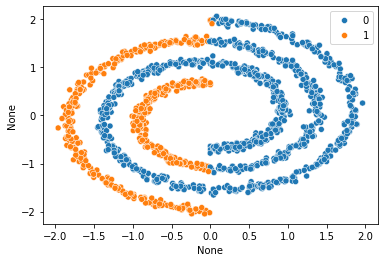

In [371]:
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=preds)

In [366]:
len(ph)

29

<Axes: xlabel='None', ylabel='None'>

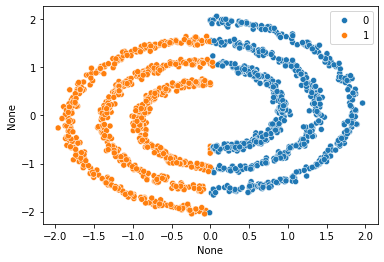

In [363]:
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=ph[0])

<Axes: xlabel='None', ylabel='None'>

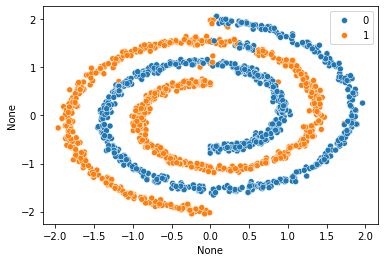

In [370]:
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=ph[28])